## Grupo

- Dayvison
- Vinicius
- Jonas
- Nathan

### Dataset Description

O **Test.csv** é um dataset com exemplos para o teste, ou seja, para validar o modelo de aprendizado e ver como ele está se saindo, possuindo o caminho das imagens, sua classificação, largura, altura etc.

O **Train.csv** é um dataset com exemplos para o treinamento do modelo, possuindo o caminho das imagens, sua classificação, largura, altura etc.

O **Meta.csv** é um dataset possui o caminho das imagens que correspondem a classificação, por exemplo, o número 14 é o Stop, a imagem referente é a de uma placa de Stop.

O **Labels.csv** é um dataset com 43 entradas e duas colunas em que a coluna ClassId é a coluna das classificações e SignName é o que a placa quer dizer.

Temos também três pastas com as imagens, são elas: **Meta**, **Train** e **Test**; Onde cada uma delas contém as imagens referentes ao nome das pastas, por exemplo, a pasta Train possui as imagens para o treinamento.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import seaborn as sns

In [2]:
# carregando os datasets
test_df = pd.read_csv("./Test.csv")
meta_df = pd.read_csv("./Meta.csv")
train_df = pd.read_csv("./Train.csv")
labels_df = pd.read_csv("./Labels.csv")

## Data Exploration

In [3]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [4]:
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [5]:
meta_df.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [6]:
labels_df.head() 

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


Ordenei o test_df para poder plotar um exemplo.

In [7]:
test_df.sort_values(by=['ClassId'])

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
5945,49,51,6,5,44,46,0,Test/05945.png
7712,31,33,6,6,25,28,0,Test/07712.png
807,45,49,5,5,40,44,0,Test/00807.png
809,32,31,6,5,27,26,0,Test/00809.png
4512,31,34,5,5,26,29,0,Test/04512.png
...,...,...,...,...,...,...,...,...
4496,32,33,5,5,26,27,42,Test/04496.png
9593,27,28,6,5,22,23,42,Test/09593.png
11842,41,43,6,6,36,38,42,Test/11842.png
5786,49,53,6,5,44,48,42,Test/05786.png


In [8]:
img = cv.imread(test_df.loc[5945]['Path'])

In [9]:
#Dimensões da imagem
img.shape[:2]

(51, 49)

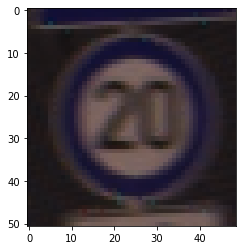

In [10]:
plt.imshow(img)

Aqui é possível ver a correlação para poder entender como as colunas se relacionam e assim ajudar na seleção dos atributos, no caso, vemos que largura e altura se correlacionam entre si e com "Roi.X1" e em diante. Como não precisamos dessas informações elas são descartadas, pois basta utilizar o .shape na matriz da imagem.

<AxesSubplot:>

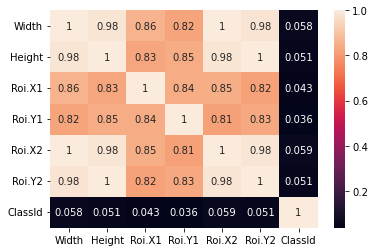

In [11]:
sns.heatmap(train_df.corr(), annot=True)

Vemos abaixo o desbalanceamento dos dados de treino e para resolver isto, podemos utilizar o *oversampling* para que todas as classes fiquem com o mesmo número de exemplos.

<AxesSubplot:xlabel='ClassId', ylabel='count'>

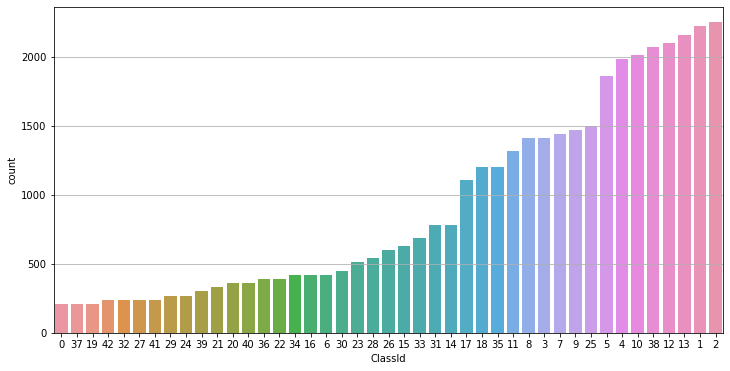

In [12]:
plt.figure(figsize=(12,6))
plt.grid()
sns.countplot(x='ClassId', data=train_df, order=train_df['ClassId'].value_counts(ascending=True).index)

Da mesma forma, temos essa situação com os dados de teste.

<AxesSubplot:xlabel='ClassId', ylabel='count'>

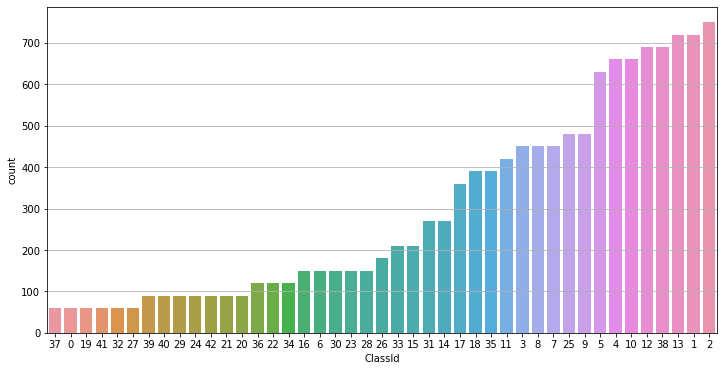

In [13]:
plt.figure(figsize=(12,6))
plt.grid()
sns.countplot(x='ClassId', data=test_df, order=test_df['ClassId'].value_counts(ascending=True).index)

Aqui, é usada uma imagem para ver como é a sua matriz e seu shape.

In [14]:
img = cv.imread("Train/20/00020_00000_00000.png")
img

array([[[ 56,  51,  46],
        [ 56,  51,  48],
        [ 54,  51,  50],
        ...,
        [ 49,  48,  50],
        [ 51,  50,  50],
        [ 49,  49,  46]],

       [[ 56,  51,  47],
        [ 54,  49,  47],
        [ 54,  50,  49],
        ...,
        [ 49,  49,  53],
        [ 55,  57,  57],
        [ 50,  50,  46]],

       [[ 56,  51,  48],
        [ 52,  48,  46],
        [ 52,  49,  47],
        ...,
        [ 53,  53,  59],
        [ 61,  64,  64],
        [ 53,  54,  48]],

       ...,

       [[ 55,  51,  47],
        [ 54,  51,  49],
        [ 54,  52,  52],
        ...,
        [ 61,  77,  89],
        [ 62,  80,  91],
        [ 49,  62,  73]],

       [[ 56,  53,  49],
        [ 59,  55,  53],
        [ 56,  53,  53],
        ...,
        [ 70,  94, 107],
        [ 66,  93,  99],
        [ 55,  73,  72]],

       [[ 55,  52,  51],
        [ 61,  55,  54],
        [ 58,  54,  53],
        ...,
        [ 80, 112, 116],
        [ 61,  98,  98],
        [ 62,  85,  80]]

In [15]:
img.shape

(26, 27, 3)

Para a rede neural receber as imagens como entrada é necessário que elas tenham o mesmo tamanho. Avaliando a distribuição nos gráficos abaixo, facilita a decisão de realizar um "resize" em todas as imagens para o tamanho 50 que é próximo da média observada após as plotagens. 

<AxesSubplot:ylabel='Frequency'>

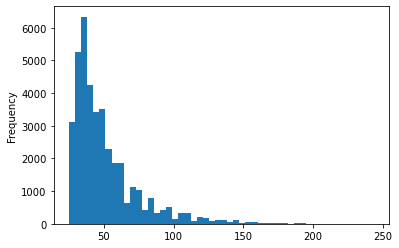

In [16]:
# distribuição da largura das imagens
train_df['Width'].plot(kind='hist', bins=50)

In [22]:
train_df['Width'].mean()

50.83587951745773

<AxesSubplot:ylabel='Frequency'>

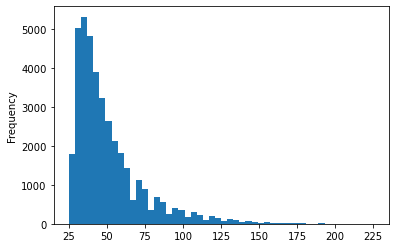

In [23]:
# distribuição da altura das imagens
train_df['Height'].plot(kind='hist', bins=50)

In [24]:
train_df['Height'].mean()

50.328929582493814

Aqui é feito o resize, e vemos como ela fica após isto.

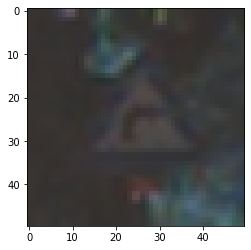

In [25]:
img = cv.resize(img,(50, 50), interpolation = cv.INTER_CUBIC)
plt.imshow(img)

Utilizo o info para ver se temos dados nulos.

In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


## Data Transformation

Aqui é aplicado uma função do openCV para transformar a imagem numa matriz numérica e é adicionado uma coluna com essas matrizes, o "apply" recebe uma função como parâmetro, passando uma função lambda na coluna "path" em que o x representa cada instância e ele retorna uma matriz.

In [27]:
train_df['MatrixIMG'] = train_df['Path'].apply(lambda x: cv.imread(x))

In [28]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,MatrixIMG
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,"[[[56, 51, 46], [56, 51, 48], [54, 51, 50], [5..."
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,"[[[55, 50, 47], [55, 50, 49], [54, 50, 50], [5..."
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,"[[[57, 50, 51], [60, 51, 51], [57, 51, 50], [5..."
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,"[[[54, 49, 49], [55, 50, 49], [55, 50, 48], [5..."
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,"[[[55, 50, 50], [56, 50, 51], [54, 49, 51], [5..."


Após a transformação, é feito um resize em todas as matrizes, para que fiquem do mesmo tamanho, (50,50).

In [29]:
train_df['MatrixIMG'] = train_df['MatrixIMG'].apply(lambda img: cv.resize(img,(50, 50), interpolation = cv.INTER_CUBIC))

Foi feito uma função que transforma em escala de cinzas para que o shape (50,50,3) vá para (50,50).

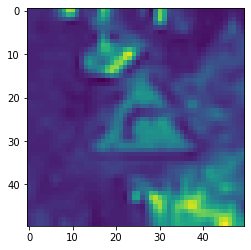

In [30]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

plt.imshow(rgb2gray(train_df['MatrixIMG'][0]))

In [31]:
train_df['MatrixIMG'][0].shape

(50, 50, 3)

In [32]:
rgb2gray(train_df['MatrixIMG'][0]).shape

(50, 50)

Assim, é aplicado a função "rgb2gray" para todas as imagens.

In [33]:
train_df['MatrixIMG'] = train_df['MatrixIMG'].apply(rgb2gray)

Após isso, todas as imagens são normalizadas para que uma feature da imagem não se saia por cima de outra na hora do treinamento.

In [34]:
train_df['MatrixIMG'] = train_df['MatrixIMG'].apply(lambda x: x/255.0)

In [48]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,MatrixIMG
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,"[[0.2036054901960784, 0.2036054901960784, 0.20..."
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,"[[0.200578431372549, 0.20102549019607843, 0.20..."
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,"[[0.20353882352941174, 0.20588313725490195, 0...."
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,"[[0.197998431372549, 0.197998431372549, 0.2014..."
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,"[[0.20191960784313726, 0.20309176470588233, 0...."


## Model Selection

Para o modelo de aprendizado, a princípio, foi cogitado utilizar o KNN,  mas seria custoso e se eu não for mostrado nenhum exemplo de alguma classe, ele nunca acertará. 

Foi preferível utilizar a rede convolucional, porque mesmo que os dados estejam desbalanceados, ainda possuímos muitos dados. 

Foi utilizado a inicialização dos pesos em cada camada com a distribuição normal, e um *regularizador L1* apenas na primeira camada para que os pesos sejam baixos e implementei um *early stopping* para poder evitar o *overfitting*.

In [49]:
model = tf.keras.models.Sequential([
     
     tf.keras.layers.Conv2D(10, (5,5), padding='same', input_shape=(50,50,1), kernel_initializer="normal", activation='relu', 
                           kernel_regularizer=tf.keras.regularizers.l1(0.01)),
     
     tf.keras.layers.MaxPooling2D((2,2)),
     
     tf.keras.layers.Conv2D(15, (5,5), activation='relu', kernel_initializer="normal"),
     
     tf.keras.layers.MaxPooling2D((2,2)),
     tf.keras.layers.Flatten(),
     
     tf.keras.layers.Dense(100, activation='relu', kernel_initializer="normal"),
     tf.keras.layers.Dense(50, activation='relu', kernel_initializer="normal"),
     tf.keras.layers.Dense(43, activation='softmax')
  
 ])
       
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])     

callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0, patience=10, verbose=1, mode="auto") 

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 50, 50, 10)        260       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 10)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 15)        3765      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 10, 15)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1500)              0         
                                                                 
 dense_3 (Dense)             (None, 100)              

## Data Featuring

Foi utilizado apenas a coluna das matrizes das imagens para o treinamento, as outras colunas não são necessárias.

In [51]:
X_train = train_df['MatrixIMG']
y_train = train_df[['ClassId']].values

Foi colocado em cada exemplo em um array para poder utilizar o *reshape*, para colocar esse shape (X_train.shape[0], 50, 50, 1) , pois assim podermos passar como entrada na rede.

In [52]:
exemplos = []

for i in range(len(X_train)):
    exemplos.append(X_train[i])

In [53]:
X_train = np.array(exemplos)

In [54]:
X_train = X_train.reshape((X_train.shape[0], 50, 50, 1))

In [55]:
X_train.shape

(39209, 50, 50, 1)

In [56]:
y_train.shape

(39209, 1)

Como há um problema de classificação multiclasse, temos que utilizar o *one hot encoder*, para que a saída da rede neural seja uma probabilidade de ser de alguma classe, onde tem a maior probabilidade é colocada como 1, e para a função de custo, que necessita que seja utilizado o *one hot encoder*.  

In [57]:
one_hot = OneHotEncoder(sparse=False)

In [58]:
y_train = one_hot.fit_transform(y_train)

In [59]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

## Model Validation

É aplicado os mesmos métodos que foram aplicados no treino para assim conseguirmos fazer as predições.

In [60]:
test_df['MatrixIMG'] = test_df['Path'].apply(lambda x: cv.imread(x))
test_df['MatrixIMG'] = test_df['MatrixIMG'].apply(lambda img: cv.resize(img,(50, 50), interpolation = cv.INTER_CUBIC))
test_df['MatrixIMG'] = test_df['MatrixIMG'].apply(rgb2gray)
test_df['MatrixIMG'] = test_df['MatrixIMG'].apply(lambda x: x/255.0)

In [61]:
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,MatrixIMG
0,53,54,6,5,48,49,16,Test/00000.png,"[[0.5718654901960785, 0.5711403921568626, 0.56..."
1,42,45,5,5,36,40,1,Test/00001.png,"[[0.2521760784313726, 0.29387647058823524, 0.2..."
2,48,52,6,6,43,47,38,Test/00002.png,"[[0.1520250980392157, 0.1566713725490196, 0.15..."
3,27,29,5,5,22,24,33,Test/00003.png,"[[0.4957462745098039, 0.42985372549019607, 0.3..."
4,60,57,5,5,55,52,11,Test/00004.png,"[[0.13389372549019607, 0.13434078431372548, 0...."


In [62]:
X_test = test_df['MatrixIMG']
y_test = test_df[['ClassId']].values

In [63]:
exemplos_test = []

for i in range(len(X_test)):
    exemplos_test.append(X_test[i])

In [64]:
X_test = np.array(exemplos_test)
X_test = X_test.reshape((X_test.shape[0], 50, 50, 1))

In [65]:
X_test.shape

(12630, 50, 50, 1)

In [66]:
y_test = one_hot.fit_transform(y_test)

In [67]:
history = model.fit(x=X_train, y=y_train, epochs=10, callbacks=[callback], validation_data=(X_test, y_test))

Epoch 1/10
1226/1226 [==============================] - 26s 21ms/step - loss: 1.3499 - accuracy: 0.6603 - val_loss: 0.8526 - val_accuracy: 0.8213
Epoch 2/10
1226/1226 [==============================] - 25s 20ms/step - loss: 0.3748 - accuracy: 0.9293 - val_loss: 0.6470 - val_accuracy: 0.8771
Epoch 3/10
1226/1226 [==============================] - 25s 20ms/step - loss: 0.2459 - accuracy: 0.9567 - val_loss: 0.5401 - val_accuracy: 0.8987
Epoch 4/10
1226/1226 [==============================] - 24s 20ms/step - loss: 0.1798 - accuracy: 0.9706 - val_loss: 0.5157 - val_accuracy: 0.9008
Epoch 5/10
1226/1226 [==============================] - 32s 26ms/step - loss: 0.1439 - accuracy: 0.9775 - val_loss: 0.4823 - val_accuracy: 0.9085
Epoch 6/10
1226/1226 [==============================] - 24s 20ms/step - loss: 0.1158 - accuracy: 0.9838 - val_loss: 0.4424 - val_accuracy: 0.9154
Epoch 7/10
1226/1226 [==============================] - 32s 26ms/step - loss: 0.0995 - accuracy: 0.9842 - val_loss: 0.5064 -

In [68]:
y_pred = model.predict(X_test)

In [69]:
label = [str(i) for i in range(43)]

Para poder utilizar o classification_report, foi usado a função argmax() com o axis=1, pois assim pegamos as linhas e vemos o índice do maior valor, que no caso é o número 1 e o índice em que se encontra é a classificação.

In [70]:
y_test.argmax(axis=1)

array([16,  1, 38, ...,  6,  7, 10], dtype=int64)

In [71]:
y_pred.argmax(axis=1)

array([16,  1, 38, ...,  3,  7, 10], dtype=int64)

Notemos que a falta de dados influenciou na quantidade de acertos, temos algumas classes com a precisão muito baixa, em torno de 60% e com a *f1-score* que é uma média harmônica entre precisão e recall baixa também, sendo que quanto maior, melhor.

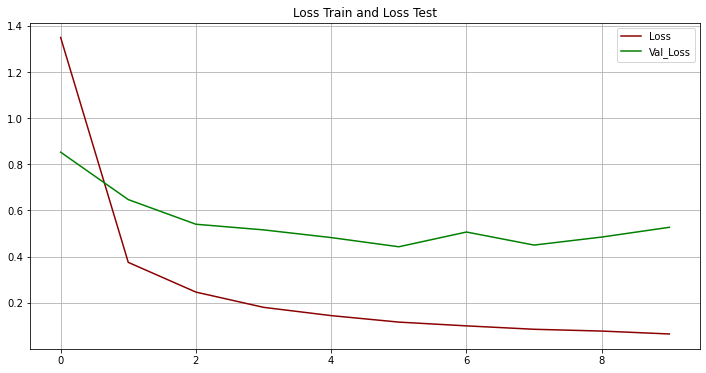

In [74]:
plt.figure(figsize=(12,6))
plt.grid()
plt.title('Loss Train and Loss Test')
plt.plot(history.history['loss'], color='darkred', label='Loss')
plt.plot(history.history['val_loss'], color='green', label='Val_Loss')
plt.legend()

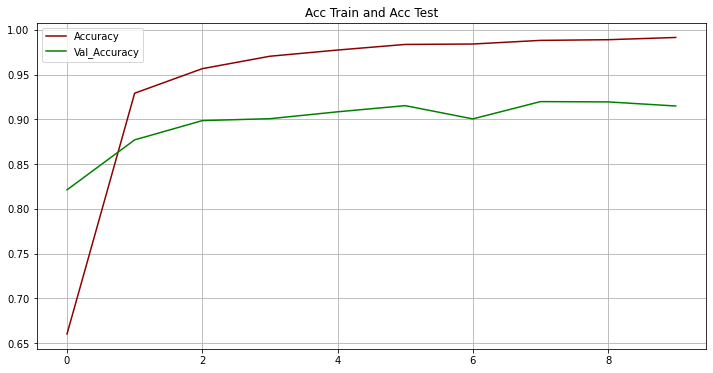

In [75]:
plt.figure(figsize=(12,6))
plt.grid()
plt.title('Acc Train and Acc Test')
plt.plot(history.history['accuracy'], color='darkred', label='Accuracy')
plt.plot(history.history['val_accuracy'], color='green', label='Val_Accuracy')
plt.legend()

In [76]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=label))

              precision    recall  f1-score   support

           0       0.80      0.92      0.85        60
           1       0.95      0.91      0.93       720
           2       0.92      0.96      0.94       750
           3       0.75      0.96      0.84       450
           4       0.99      0.91      0.95       660
           5       0.93      0.89      0.91       630
           6       0.99      0.79      0.88       150
           7       0.95      0.82      0.88       450
           8       0.90      0.90      0.90       450
           9       0.93      0.96      0.95       480
          10       0.97      0.97      0.97       660
          11       0.92      0.88      0.90       420
          12       0.99      0.94      0.97       690
          13       1.00      0.99      0.99       720
          14       0.95      0.97      0.96       270
          15       0.94      0.98      0.96       210
          16       0.99      0.98      0.98       150
          17       0.99    

Foi feito uma comparação de vinte respostas verdadeiras com as vinte preditas.

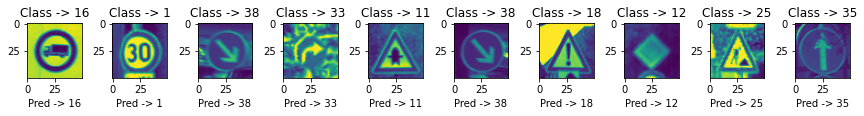

In [91]:
rows = 1
cols = 10
axes = []
fig = plt.figure(figsize=(12,6))

for a in range(rows*cols):
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Class -> "+str(y_test[:10].argmax(axis=1)[a]))
    axes[-1].set_title(subplot_title)
    subplot_xlabel=("Pred -> "+str(y_pred[:10].argmax(axis=1)[a]))
    axes[-1].set_xlabel(subplot_xlabel)
    plt.imshow(X_test[a])

fig.tight_layout()

Abaixo temos os prints do que significa os numeros em 'Class' nos plots acima

In [98]:
for number in y_test[:10].argmax(axis=1):
    
    text_class = labels_df[labels_df['ClassId'] == number]['SignName'].values[0]

    print(f'Classe: {number} , Descrição: {text_class}')

Classe: 16 , Descrição: Vehicles over 3.5 metric tons prohibited
Classe: 1 , Descrição: Speed limit (30km/h)
Classe: 38 , Descrição: Keep right
Classe: 33 , Descrição: Turn right ahead
Classe: 11 , Descrição: Right-of-way at the next intersection
Classe: 38 , Descrição: Keep right
Classe: 18 , Descrição: General caution
Classe: 12 , Descrição: Priority road
Classe: 25 , Descrição: Road work
Classe: 35 , Descrição: Ahead only


In [93]:
indices = []
for i in range(len(y_test.argmax(axis=1))):
    if y_test.argmax(axis=1)[i] != y_pred.argmax(axis=1)[i]:
        indices.append(i)
        
dez_primeiros = indices[:10]

Temos as dez imagens que foram preditas erradas.

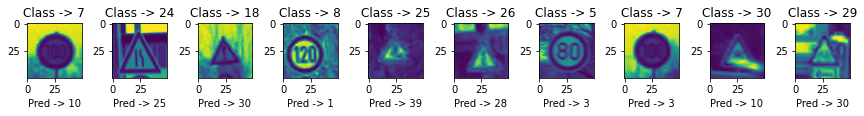

In [94]:
rows = 1
cols = 10
axes = []
fig = plt.figure(figsize=(12,6))

for a in range(rows*cols):
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Class -> "+str(y_test.argmax(axis=1)[dez_primeiros[a]]))
    axes[-1].set_title(subplot_title)
    subplot_xlabel=("Pred -> "+str(y_pred.argmax(axis=1)[dez_primeiros[a]]))
    axes[-1].set_xlabel(subplot_xlabel)
    plt.imshow(X_test[dez_primeiros[a]])

fig.tight_layout()

Abaixo temos a descrição das 'Class' dos plots acima e os 'Pred'.

In [105]:
for number in dez_primeiros:
    
    text_class = labels_df[labels_df['ClassId'] == y_test.argmax(axis=1)[number]]['SignName'].values[0]
    
    print(f'Classe: {y_test.argmax(axis=1)[number]} , Descrição: {text_class}')

print('')
for number in dez_primeiros:
    
    text_predict = labels_df[labels_df['ClassId'] == y_pred.argmax(axis=1)[number]]['SignName'].values[0]

    print(f'Predição: {y_pred.argmax(axis=1)[number]}, Descrição: {text_predict}')

Classe: 7 , Descrição: Speed limit (100km/h)
Classe: 24 , Descrição: Road narrows on the right
Classe: 18 , Descrição: General caution
Classe: 8 , Descrição: Speed limit (120km/h)
Classe: 25 , Descrição: Road work
Classe: 26 , Descrição: Traffic signals
Classe: 5 , Descrição: Speed limit (80km/h)
Classe: 7 , Descrição: Speed limit (100km/h)
Classe: 30 , Descrição: Beware of ice/snow
Classe: 29 , Descrição: Bicycles crossing

Predição: 10, Descrição: No passing for vehicles over 3.5 metric tons
Predição: 25, Descrição: Road work
Predição: 30, Descrição: Beware of ice/snow
Predição: 1, Descrição: Speed limit (30km/h)
Predição: 39, Descrição: Keep left
Predição: 28, Descrição: Children crossing
Predição: 3, Descrição: Speed limit (60km/h)
Predição: 3, Descrição: Speed limit (60km/h)
Predição: 10, Descrição: No passing for vehicles over 3.5 metric tons
Predição: 30, Descrição: Beware of ice/snow


Função que passando o path da imagem, ele retorna a classificação dada pelo modelo e o que a placa quer dizer.

Predict = 7 , Speed limit (100km/h)


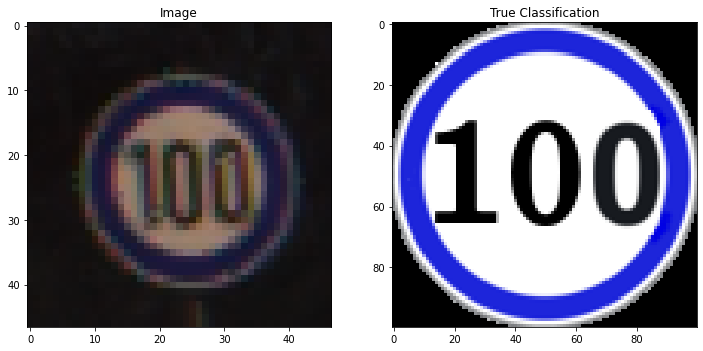

In [106]:
def prediction(path):
    img = cv.imread(path)
    axes = []
    fig = plt.figure(figsize=(12,6))
    
    axes.append( fig.add_subplot(1, 2, 1) )
    subplot_title=("Image")
    axes[-1].set_title(subplot_title)
    plt.imshow(img)
    
    res = rgb2gray(cv.resize(img,(50, 50), interpolation = cv.INTER_CUBIC))
    res = res.reshape(1,50,50,1)/255.0
    
    predict = model.predict(res).argmax()
    
    meta_class = meta_df[meta_df['ClassId'] == predict]['Path'].values[0]
    
    axes.append( fig.add_subplot(1, 2, 2) )
    subplot_title=("True Classification")
    axes[-1].set_title(subplot_title)
    plt.imshow(cv.imread(meta_class))
    
    text_class = labels_df[labels_df['ClassId'] == predict]['SignName'].values[0]
    
    print(f'Predict = {predict} , {text_class}')
    
prediction("Test/11000.png")    

## Solve the problem of unbalanced data

Utilizando a biblioteca imblearn, conseguimos resolver o problema de desbanlanceamento de dados, tanto no treino, quanto no teste.

In [109]:
from imblearn.over_sampling import SMOTE

Aqui, é colocado cada instância em um array para podermos ajeitar seu shape, multiplicando 50 por 50, ou seja (train.shape[0],-1), pois assim conseguimos gerar mais dados.

In [110]:
exemplos = []

for i in range(len(train_df)):
    exemplos.append(train_df['MatrixIMG'][i])

exemplos2 = []

for i in range(len(test_df)):
    exemplos2.append(test_df['MatrixIMG'][i])

In [111]:
train = np.array(exemplos)

In [112]:
train = train.reshape(train.shape[0], -1)

X_smote e y_smote são os dados aumentados para treino e X_test_smote e y_test_smote para o teste, gerando o suficiente para que chegue na quantidade de instâncias da classe com mais instâncias e que no caso são 2250, então cada classe terá 2250 instâncias e após isso, voltamos ao shape original, e o random_state é 42 para que possa ser reproduzido com os mesmos resultados.

In [113]:
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(train, train_df[['ClassId']].values)

In [114]:
X_smote.shape

(96750, 2500)

In [115]:
X_smote = X_smote.reshape(X_smote.shape[0],50,50,1)

In [116]:
X_smote.shape

(96750, 50, 50, 1)

In [117]:
y_smote = y_smote.reshape(y_smote.shape[0],1)

In [118]:
test = np.array(exemplos2)

In [119]:
test = test.reshape(test.shape[0],-1)
X_test_smote, y_test_smote = sm.fit_resample(test, test_df[['ClassId']].values)

In [120]:
y_test_smote = y_test_smote.reshape(y_test_smote.shape[0],1)

In [121]:
X_test_smote = X_test_smote.reshape(X_test_smote.shape[0],50,50,1)

In [122]:
y_smote = one_hot.fit_transform(y_smote)
y_test_smote = one_hot.fit_transform(y_test_smote)

In [123]:
y_smote

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

É necessário rodar novamento o modelo para não utilizar o modelo já treinado.

In [124]:
model = tf.keras.models.Sequential([
     
     tf.keras.layers.Conv2D(10, (5,5), padding='same', input_shape=(50,50,1), kernel_initializer="normal", activation='relu', 
                           kernel_regularizer=tf.keras.regularizers.l1(0.01)),
     
     tf.keras.layers.MaxPooling2D((2,2)),
     
     tf.keras.layers.Conv2D(15, (5,5), activation='relu', kernel_initializer="normal"),
     
     tf.keras.layers.MaxPooling2D((2,2)),
     tf.keras.layers.Flatten(),
     
     tf.keras.layers.Dense(100, activation='relu', kernel_initializer="normal"),
     tf.keras.layers.Dense(50, activation='relu', kernel_initializer="normal"),
     tf.keras.layers.Dense(43, activation='softmax')
  
 ])
       
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])     

callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0, patience=10, verbose=1, mode="auto") 

In [125]:
history_smoth = model.fit(x=X_smote, y=y_smote, epochs=10, callbacks=[callback], validation_data=(X_test_smote,y_test_smote))

Epoch 1/10
3024/3024 [==============================] - 64s 21ms/step - loss: 0.6109 - accuracy: 0.8671 - val_loss: 0.9642 - val_accuracy: 0.8572
Epoch 2/10
3024/3024 [==============================] - 62s 21ms/step - loss: 0.1396 - accuracy: 0.9790 - val_loss: 0.6780 - val_accuracy: 0.8840
Epoch 3/10
3024/3024 [==============================] - 86s 28ms/step - loss: 0.0819 - accuracy: 0.9881 - val_loss: 0.7068 - val_accuracy: 0.8738
Epoch 4/10
3024/3024 [==============================] - 86s 28ms/step - loss: 0.0573 - accuracy: 0.9915 - val_loss: 0.7711 - val_accuracy: 0.8681
Epoch 5/10
3024/3024 [==============================] - 86s 28ms/step - loss: 0.0452 - accuracy: 0.9933 - val_loss: 0.6600 - val_accuracy: 0.8952
Epoch 6/10
3024/3024 [==============================] - 91s 30ms/step - loss: 0.0378 - accuracy: 0.9951 - val_loss: 0.6624 - val_accuracy: 0.8997
Epoch 7/10
3024/3024 [==============================] - 91s 30ms/step - loss: 0.0326 - accuracy: 0.9956 - val_loss: 0.5952 -

Aqui é testado a predição do novo modelo nos dados de teste antes do aumento.

In [126]:
y_pred = model.predict(X_test)

Aqui, notemos que a média de acertos aumentou até aos 90% em comparação com o modelo anterior que foi treinado com os dados originais, comprovando que realmente melhorou ter balanceado os dados.

In [127]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=label))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77        60
           1       0.89      0.96      0.93       720
           2       0.94      0.94      0.94       750
           3       0.92      0.88      0.90       450
           4       0.98      0.88      0.93       660
           5       0.83      0.97      0.89       630
           6       0.97      0.85      0.91       150
           7       0.91      0.90      0.91       450
           8       0.92      0.89      0.91       450
           9       0.98      0.91      0.94       480
          10       0.99      0.96      0.98       660
          11       0.91      0.98      0.94       420
          12       1.00      0.98      0.99       690
          13       0.94      0.99      0.97       720
          14       0.99      0.99      0.99       270
          15       0.97      0.96      0.97       210
          16       0.98      0.99      0.98       150
          17       1.00    

In [128]:
y_pred_smoth = model.predict(X_test_smote)

Aqui, notemos que a média de acertos aumentou até aos 92% após o balanceamento dos dados de treino e teste, além de aumentar a *f1-score* em algumas classes.

In [129]:
print(classification_report(y_test_smote.argmax(axis=1), y_pred_smoth.argmax(axis=1), target_names=label))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86       750
           1       0.76      0.97      0.85       750
           2       0.92      0.94      0.93       750
           3       0.91      0.89      0.90       750
           4       0.93      0.89      0.91       750
           5       0.74      0.97      0.84       750
           6       0.98      0.85      0.91       750
           7       0.88      0.90      0.89       750
           8       0.91      0.91      0.91       750
           9       0.94      0.91      0.92       750
          10       0.99      0.97      0.98       750
          11       0.90      0.98      0.94       750
          12       1.00      0.98      0.99       750
          13       0.92      0.99      0.96       750
          14       0.99      0.99      0.99       750
          15       0.99      0.97      0.98       750
          16       0.99      0.99      0.99       750
          17       1.00    

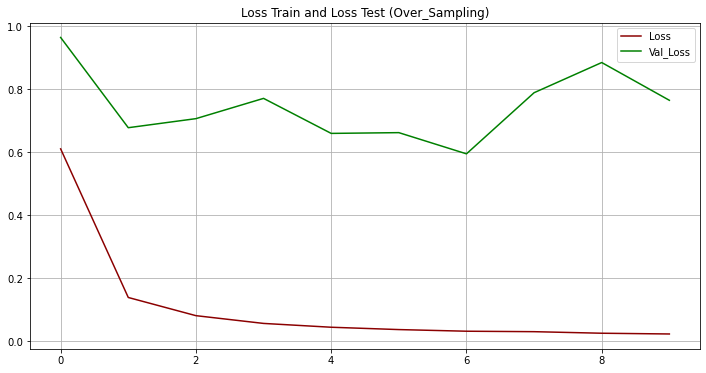

In [141]:
plt.figure(figsize=(12,6))
plt.grid()
plt.title('Loss Train and Loss Test (Over_Sampling)')
plt.plot(history_smoth.history['loss'], color='darkred', label='Loss')
plt.plot(history_smoth.history['val_loss'], color='green', label='Val_Loss')
plt.legend()

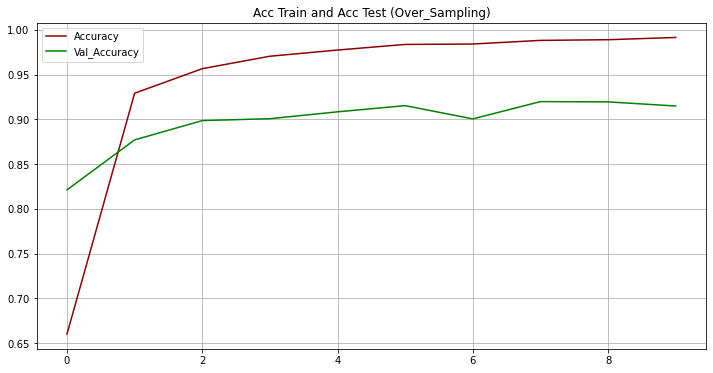

In [142]:
plt.figure(figsize=(12,6))
plt.grid()
plt.title('Acc Train and Acc Test (Over_Sampling)')
plt.plot(history.history['accuracy'], color='darkred', label='Accuracy')
plt.plot(history.history['val_accuracy'], color='green', label='Val_Accuracy')
plt.legend()

## Taking images from the internet for model validation

Para que o modelo classifique bem, foi feito um corte em cada imagem para que fique apenas a placa, pois não consegui criar um algoritmo que identifique apenas a placa numa imagem e após isso, determinar sua classificação.

Predict = 14 , Stop


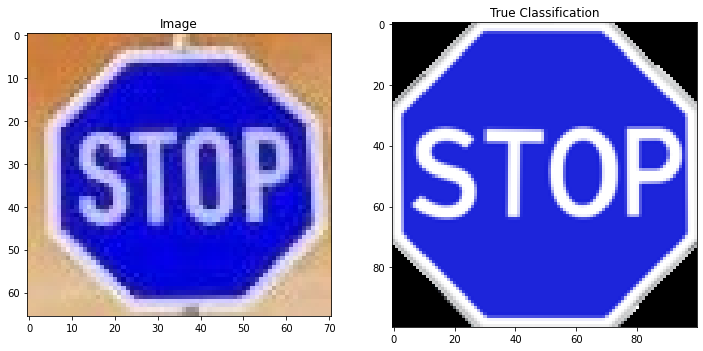

In [130]:
prediction('image_STOP.jpg')

Predict = 18 , General caution


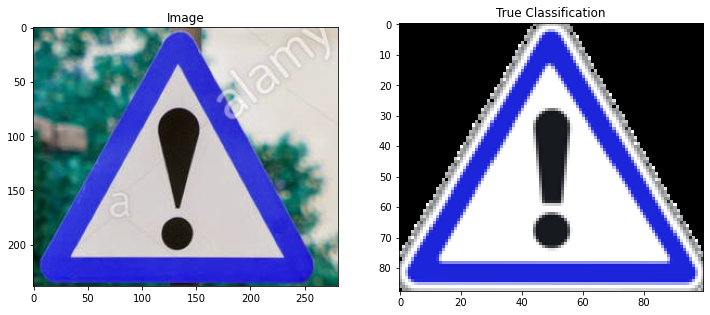

In [131]:
prediction('image1.jpg')

Predict = 33 , Turn right ahead


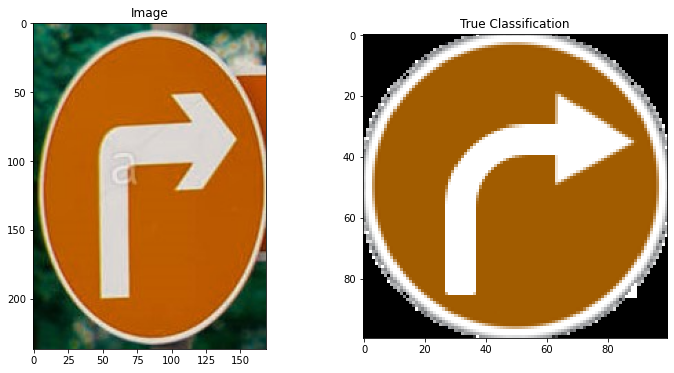

In [132]:
prediction('image2.jpg')

Predict = 35 , Ahead only


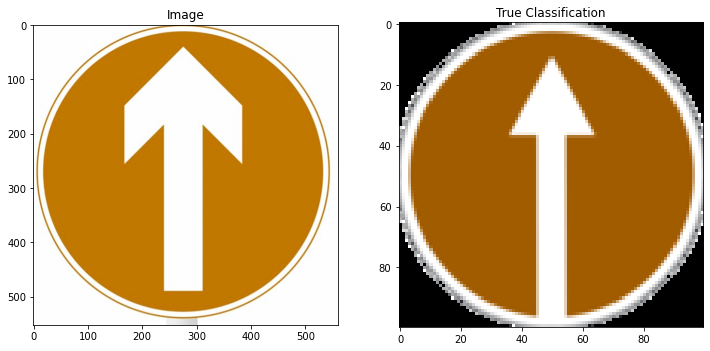

In [133]:
prediction('image3.jpg')

## Saving the model and weights

Aqui é salvo o modelo e seus pesos, para que não seja necessário treinar novamente, e no caso, o modelo salvo é o último que foi treinado.

In [134]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")

## Loading the model and weights

Carregando o modelo e os pesos, conseguimos fazer predições normalmente.

In [135]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.load_weights("model.h5")

loaded_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_test_smote, y_test_smote, verbose=0)

In [136]:
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 91.25%


## Bônus

In [137]:
img = cv.imread('sign8.jpg')

placas_cascade = cv.CascadeClassifier('stopsign_classifier.xml')

cinza = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

placas = placas_cascade.detectMultiScale(cinza, 1.3, 5)

for (x,y,w,h) in placas:
    cv.rectangle(img, (x,y), (x+w, y+h), (255,0,0),2)
    roi = img[y:y + h , x:x + w]
    res = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
    res = cv.resize(res,(50, 50), interpolation = cv.INTER_CUBIC)
    res = res.reshape(1,50,50,1)/255.0
    
    predict = loaded_model.predict(res).argmax()
    
    text = labels_df[labels_df['ClassId'] == predict]['SignName'].values[0]
    cv.putText(img,f"Predict = {text}",(10,500), cv.FONT_HERSHEY_SIMPLEX, 1,(255,255,0),2,cv.LINE_AA)
    cv.imshow('imagem', img)
    

cv.waitKey(0)
cv.destroyAllWindows()

In [138]:
try:    
    cap = cv.VideoCapture('video_pare.mp4')

    placas_cascade = cv.CascadeClassifier('stopsign_classifier.xml')

    while True:
        ret, frame = cap.read()

        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        placas = placas_cascade.detectMultiScale(gray, 1.3, 5)

        for (x,y,w,h) in placas:
            cv.rectangle(frame, (x,y), (x+w, y+h), (255,0,0),2)

            roi = frame[y:y + h , x:x + w]
            res = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
            res = cv.resize(res,(50, 50), interpolation = cv.INTER_CUBIC)
            res = res.reshape(1,50,50,1)/255.0

            predict = loaded_model.predict(res).argmax()

            text = labels_df[labels_df['ClassId'] == predict]['SignName'].values[0]
            cv.putText(frame,f"Predict = {text}",(10,500), cv.FONT_HERSHEY_SIMPLEX, 1,(255,255,0),2,cv.LINE_AA)

        cv.imshow('frame', frame)

        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv.destroyAllWindows()

except:
    
    cap.release()
    cv.destroyAllWindows()